In [1]:
USE_GPU    = True
MODEL_NAME = "run_1"

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs", MODEL_NAME)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from coco import coco_keypoints

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [1]:
## general imports
import json
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [2]:
## set paths
dataDir  = COCO_DATA_DIR
dataType = 'val2014'
annType  = 'person_keypoints'
teamName = 'fakekeypoints100'

annFile  = '%s/annotations/%s_%s.json'%(dataDir, annType, dataType)
resFile  = '%s/detections/%s_%s_%s_results.json'%(dataDir, teamName, annType, dataType)

print("{:10}[{}]".format('annFile:',annFile))
print("{:10}[{}]".format('resFile:',resFile))

gt_data   = json.load(open(annFile,'rb'))
imgs_info = {i['id']:{'id':i['id'] ,
                      'width':i['width'],
                      'height':i['height']}
                       for i in gt_data['images']}

annFile:  [./annotations/person_keypoints_val2014.json]
resFile:  [./detections/fakekeypoints100_keypoints_val2014_results.json]


In [3]:
team_dts = json.load(open(resFile,'rb'))
team_dts = [d for d in team_dts if d['image_id'] in imgs_info]

team_img_ids = set([d['image_id'] for d in team_dts])
print("Loaded [{}] instances in [{}] images.".format(len(team_dts),len(imgs_info)))

## load ground truth annotations
coco_gt = COCO( annFile )

## initialize COCO detections api
coco_dt   = coco_gt.loadRes( team_dts )

## initialize COCO analyze api
coco_analyze = COCOanalyze(coco_gt, coco_dt, 'keypoints')
if teamName == 'fakekeypoints100':
    imgIds  = sorted(coco_gt.getImgIds())[0:100]
    coco_analyze.cocoEval.params.imgIds = imgIds

Loaded [125] instances in [40504] images.
loading annotations into memory...
Done (t=2.20s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.05s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.642
 Average Precision  (AP) @[ IoU=0.55      | area=   all | maxDets= 20 ] = 0.576
 Average Precision  (AP) @[ IoU=0.60      | area=   all | maxDets= 20 ] = 0.532
 Average Precision  (AP) @[ IoU=0.65      | area=   all | maxDets= 20 ] = 0.440
 Average Precision  (AP) @[ IoU=0.70      | area=   all | maxDets= 20 ] = 0.394
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.349
 Average Precision  (AP) @[ IoU=0.80      | area=   all | maxDets= 20 ] = 0.288
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.226
 Average Precision  (AP) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.198
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] =

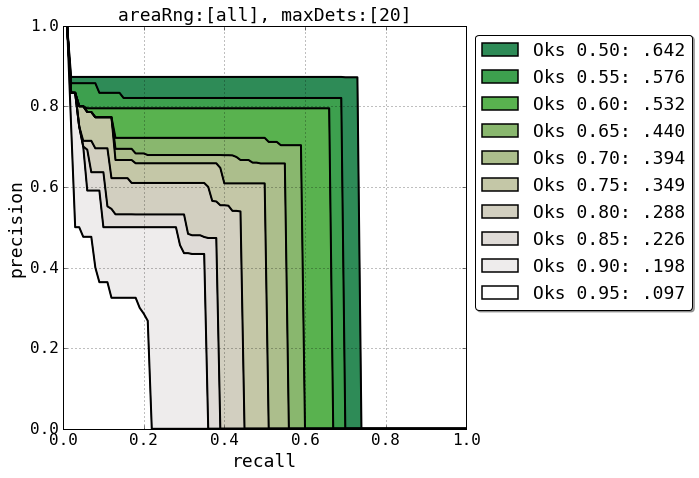

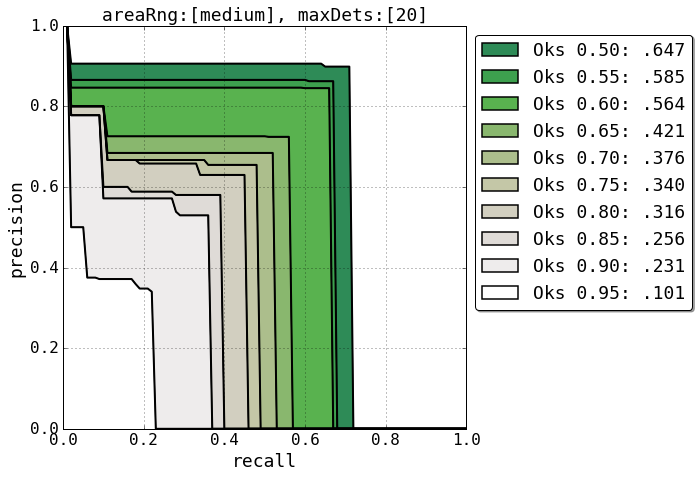

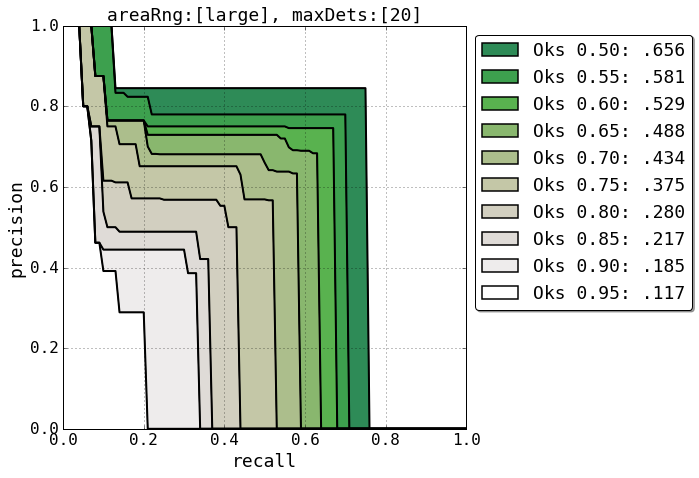

In [4]:
# use evaluate() method for standard coco evaluation
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.evaluate(verbose=True, makeplots=True)

In [5]:
## NOTE: the values below are all default

# set OKS threshold of the extended error analysis
coco_analyze.params.oksThrs       = [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]

# set OKS threshold required to match a detection to a ground truth
coco_analyze.params.oksLocThrs    = .1

# set KS threshold limits defining jitter errors
coco_analyze.params.jitterKsThrs = [.5,.85]

# set the localization errors to analyze and in what order
# note: different order will show different progressive improvement
# to study impact of single error type, study in isolation
coco_analyze.params.err_types = ['miss','swap','inversion','jitter']

# area ranges for evaluation
# 'all' range is union of medium and large
coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]] #[96 ** 2, 1e5 ** 2],[32 ** 2, 96 ** 2]
coco_analyze.params.areaRngLbl    = ['all'] # 'large','medium' 

coco_analyze.params.maxDets = [20]

In [6]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : default errors types are ['jitter','inversion','swap','miss']
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_bkgd   : analyze background false positives and false negatives (default: True)

coco_analyze.analyze(check_kpts=True, check_scores=True, check_bckgd=True)

Analyzing keypoint errors...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.06s).
DONE (t=0.12s).
Analyzing detection scores...
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.02s).
DONE (t=0.06s).
Analyzing background false positives and false negatives...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
DONE (t=1.08s).


<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
Correcting area range [all]:
Correcting error type [miss]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
Correcting error type [swap]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
Correcting error type [inversion]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.00s).
Correcting error type [jitter]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=0.03s).
<mrr:2.0

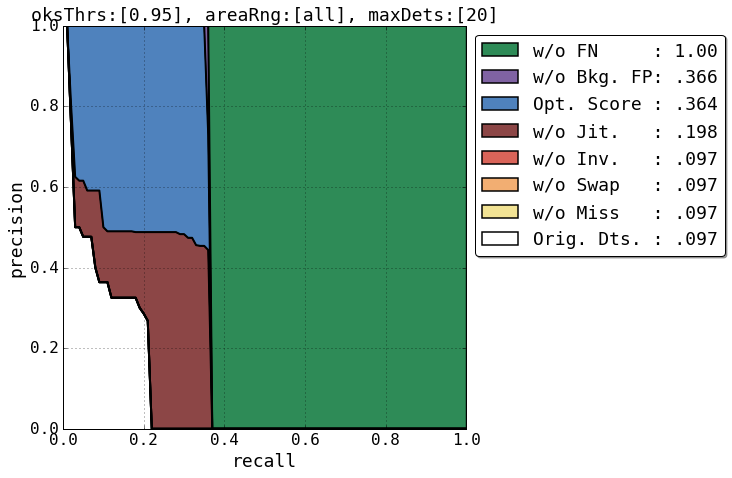

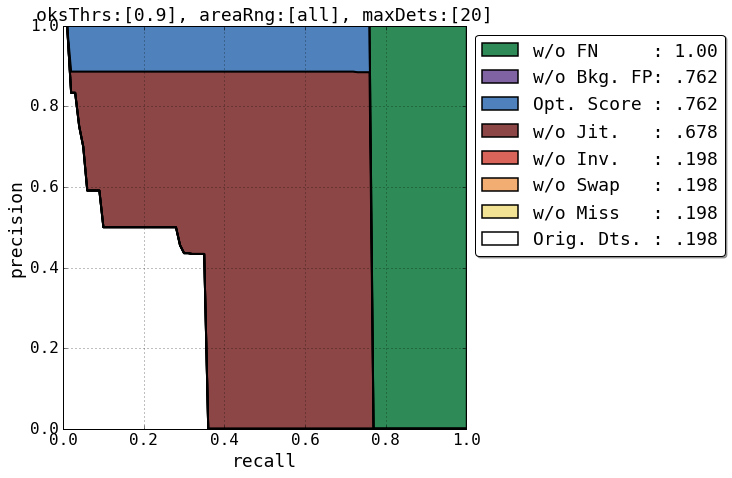

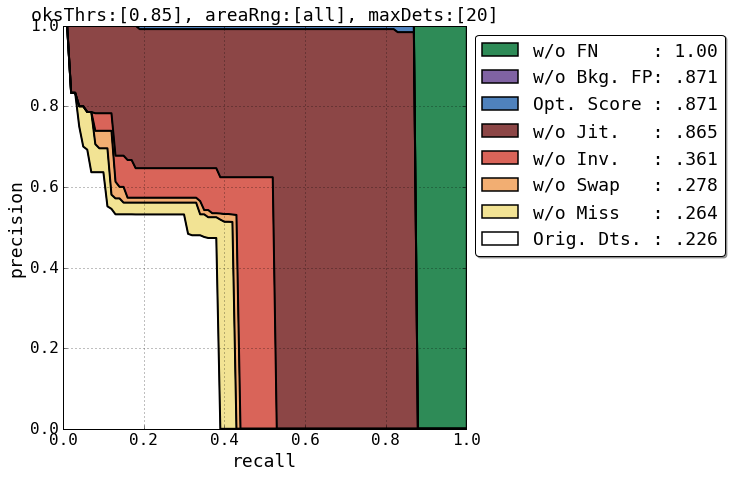

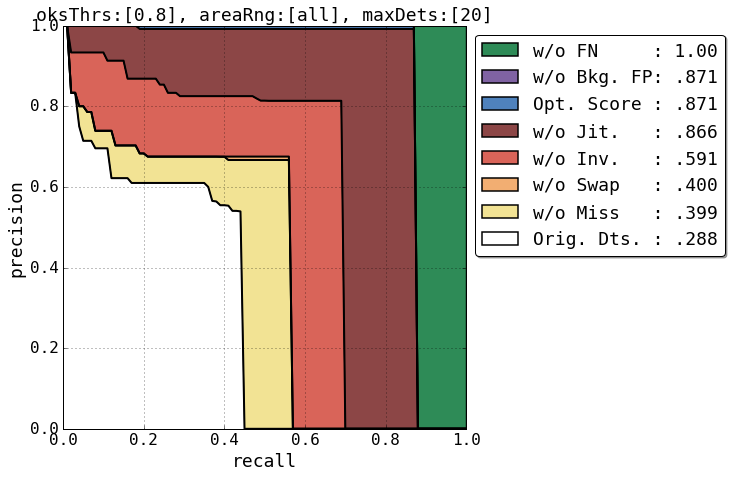

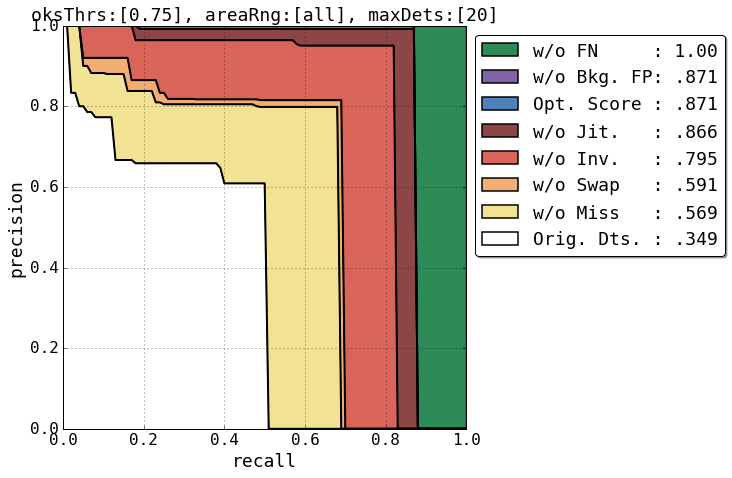

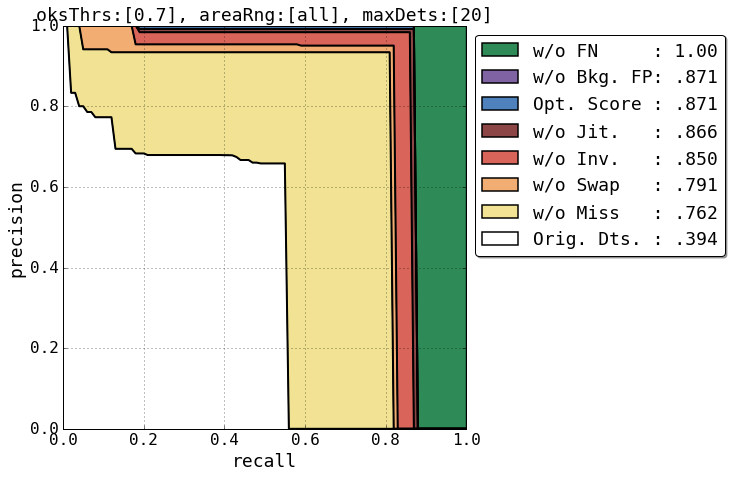

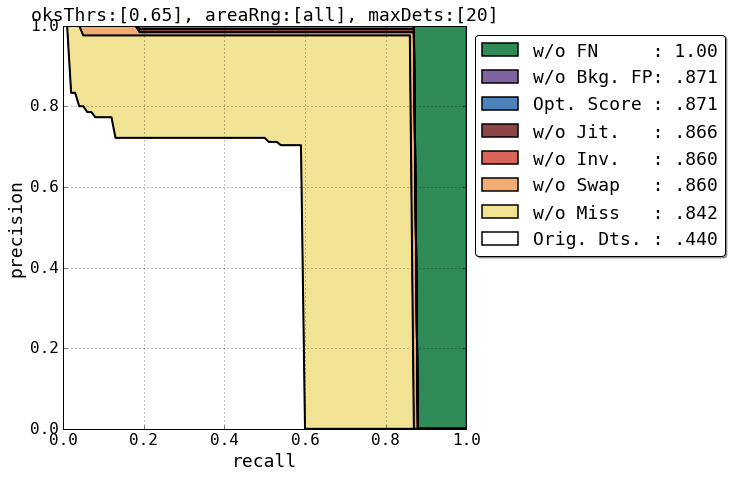

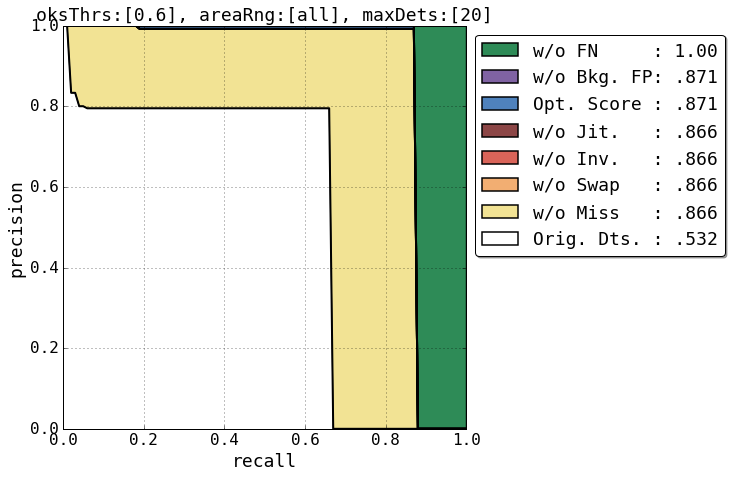

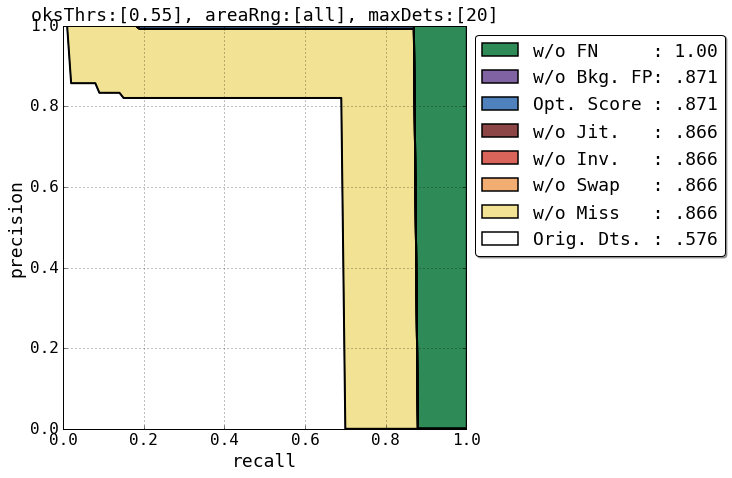

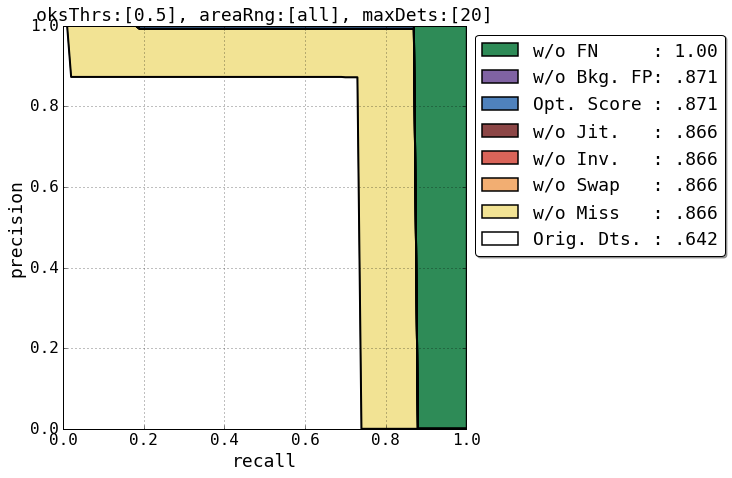

In [7]:
# use summarize() method to get the results after progressive correction of errors
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.summarize(makeplots=True)

In [8]:
## print the performance summary 
for stat in coco_analyze.stats: print stat

{'auc': 0.097010415327246996, 'err': 'baseline', 'recall': 0.21582733812949639, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.95}
{'auc': 0.19843226721690829, 'err': 'baseline', 'recall': 0.35251798561151076, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.9}
{'auc': 0.22615308868279232, 'err': 'baseline', 'recall': 0.38129496402877699, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.85}
{'auc': 0.28759578327412127, 'err': 'baseline', 'recall': 0.4460431654676259, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.8}
{'auc': 0.348584596289013, 'err': 'baseline', 'recall': 0.50359712230215825, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.75}
{'auc': 0.39366986055510872, 'err': 'baseline', 'recall': 0.5539568345323741, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.7}
{'auc': 0.44038976615612846, 'err': 'baseline', 'recall': 0.59712230215827333, 'areaRngLbl': 'all', 'maxDets': 20, 'oks': 0.65}
{'auc': 0.53221629855293218, 'err': 'baseline', 'recall': 0.6690647482014388, 'areaRngLbl': 'all', 'maxDets': 

In [9]:
## after analyze() has been called the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts['all']

i = 17
# info on keypoint detection localization error
print 'good: %s'%corrected_dts[i]['good']
print 'miss: %s'%corrected_dts[i]['miss']
print 'swap: %s'%corrected_dts[i]['swap']
print 'inv.: %s'%corrected_dts[i]['inversion']
print 'jit.: %s\n'%corrected_dts[i]['jitter']

# corrected keypoint locations
print 'predicted keypoints:\n %s'%corrected_dts[i]['keypoints']
print 'corrected keypoints:\n %s\n'%corrected_dts[i]['opt_keypoints']

# optimal detection score
print 'original score: %s'%corrected_dts[i]['score']
print 'optimal score:  %s\n'%corrected_dts[i]['opt_score']

good: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
miss: [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
swap: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
inv.: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
jit.: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

predicted keypoints:
 [306, 163, 2, 312, 154, 2, 296, 153, 2, 337, 139, 2, 293.875, 239.875, 0, 351, 162, 2, 281, 153, 2, 380, 253, 2, 243, 224, 2, 337, 258, 2, 254, 247, 2, 325, 269, 2, 273, 264, 2, 303, 290, 2, 240, 275, 2, 232, 419, 2, 232, 415, 2]
corrected keypoints:
 [331.00343509551465, 163.0, 2, 332.58113883008417, 154.0, 2, 320.77253374568716, 153.0, 2, 364.081547243962, 139.0, 2, 293.875, 239.875, 0, 378.8326863537415, 162.0, 2, 308.8326863537415, 153.0, 2, 407.0500432591062, 253.0, 2, 270.0500432591062, 224.0, 2, 362.93198169534145, 258.0, 2, 279.93198169534145, 247.0, 2, 325.0, 269.0, 2, 273.0, 264.0, 2, 303.0, 290.0, 2, 240.0, 275.0, 2, 232.0, 419.0, 2, 232.0, 415.0, 2]

original score: 

In [10]:
## after summarize() has been called the following variables are available

# list of the false positive detections and missed ground-truth annotations
false_pos_dts = coco_analyze.false_pos_dts
false_neg_gts = coco_analyze.false_neg_gts
for oks in coco_analyze.params.oksThrs:
    print "Oks:[%.2f] - Num.FP:[%d] - Num.FN:[%d]"%(oks,len(false_pos_dts['all',str(oks)]),len(false_neg_gts['all',str(oks)]))

Oks:[0.50] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.55] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.60] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.65] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.70] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.75] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.80] - Num.FP:[2] - Num.FN:[88030]
Oks:[0.85] - Num.FP:[3] - Num.FN:[88031]
Oks:[0.90] - Num.FP:[16] - Num.FN:[88044]
Oks:[0.95] - Num.FP:[66] - Num.FN:[88097]
